In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import invgauss

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=["#5b6c64", "#B56246", "#322B4D", "#28BC9C", "#71074E"]) 

In [22]:
def inverse_gaussian_sample_vectorized(mu, lambda_, x_n, x_u):
    """
    Vectorized version of the inverse Gaussian sampling function.
    """
    y = x_n ** 2  # std normal squared
    x = mu + (mu ** 2 * y) / (2 * lambda_) - (mu / (2 * lambda_)) * np.sqrt(4 * mu * lambda_ * y + mu ** 2 * y ** 2)
    condition = x_u <= mu / (mu + x)
    samples = np.where(condition, x, (mu ** 2) / x)
    return samples 


In [38]:
mu = 0.0014105
lam = 0.03538877
size = 10**6

In [39]:
%%timeit
rng = np.random.default_rng(seed=42)
sample1 = rng.wald(mean=mu, scale=lam, size=size)

54.6 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%%timeit
rng = np.random.default_rng(seed=42)
x_norm = rng.normal(0, 1, size)
x_uniform = rng.uniform(0, 1, size)
sample2 = inverse_gaussian_sample_vectorized(mu, lam, x_norm, x_uniform)

64.9 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%time

U = np.empty(size)
for i in range(size):
    U[i] = rng.wald(mean=mu, scale=lam, size=1)

Wall time: 2.2 s


In [42]:
%%time

x_norm = rng.normal(0, 1, size)
x_uniform = rng.uniform(0, 1, size)

U = np.empty(size)
for i in range(size):
    U[i] = inverse_gaussian_sample_vectorized(mu, lam, x_norm[i], x_uniform[i])

Wall time: 8.13 s


In [29]:
from typing import Callable
import scipy
import statsmodels.api as sm

def density_test(sample, density: Callable, bins=50, alpha=0.4, n_grid=10**4):
    fig, ax = plt.subplots()
    ax.hist(sample, bins=bins, density=True, alpha=alpha, label="Empirical density")
    x_grid = np.linspace(sample.min(), sample.max(), num=n_grid)
    ax.plot(x_grid, density(x_grid), label="PDF")
    ax.legend()
    
def cdf_test(sample, cdf: Callable, bins=50, alpha=0.4, n_grid=10**4):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    x_grid = np.linspace(sample.min(), sample.max(), num=n_grid)
    ecdf = sm.distributions.ECDF(sample)
    ax[0].plot(x_grid, cdf(x_grid), "k--", label="Exact CDF")
    ax[0].plot(x_grid, ecdf(x_grid), label=r"Empirical CDF")
    ax[0].legend()
    
    ecdf_unif = sm.distributions.ECDF(cdf(sample))
    u_grid = np.linspace(0, 1, n_grid)
    ax[1].plot(u_grid, u_grid, "k--", label="y=x")
    ax[1].plot(u_grid, ecdf_unif(u_grid), label=r"Empirical CDF of F(X)")
    ax[1].legend()

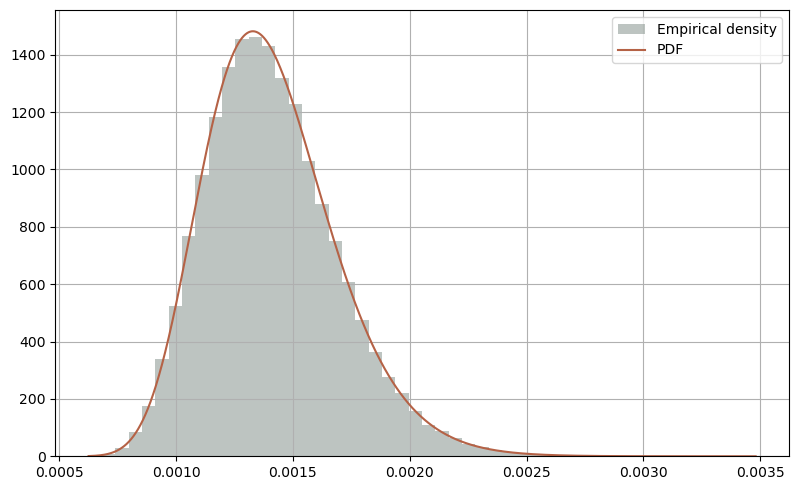

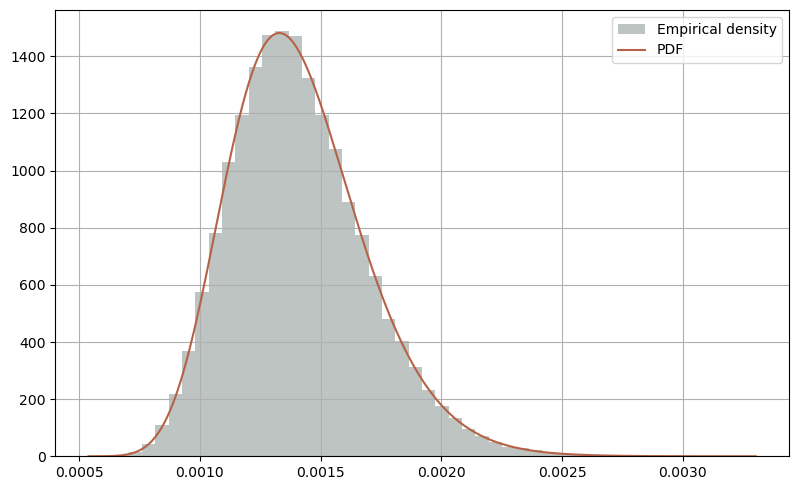

In [30]:
density_test(sample1, lambda x: invgauss.pdf(x=x, mu=mu/lam, loc=0, scale=lam))
density_test(sample2, lambda x: invgauss.pdf(x=x, mu=mu/lam, loc=0, scale=lam))

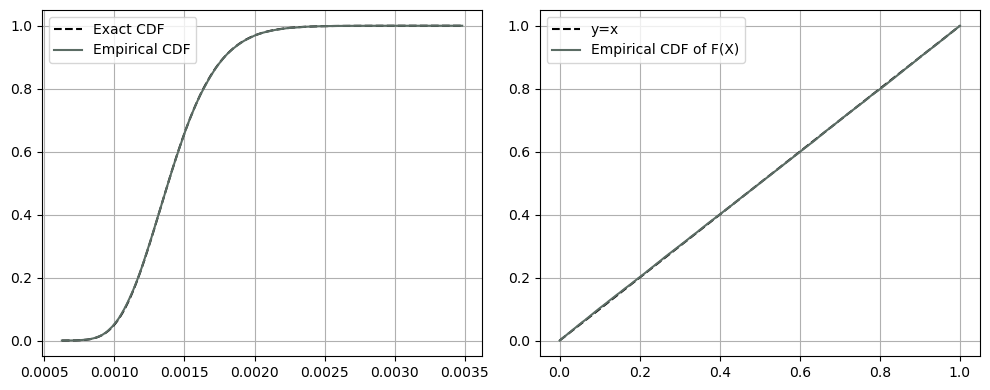

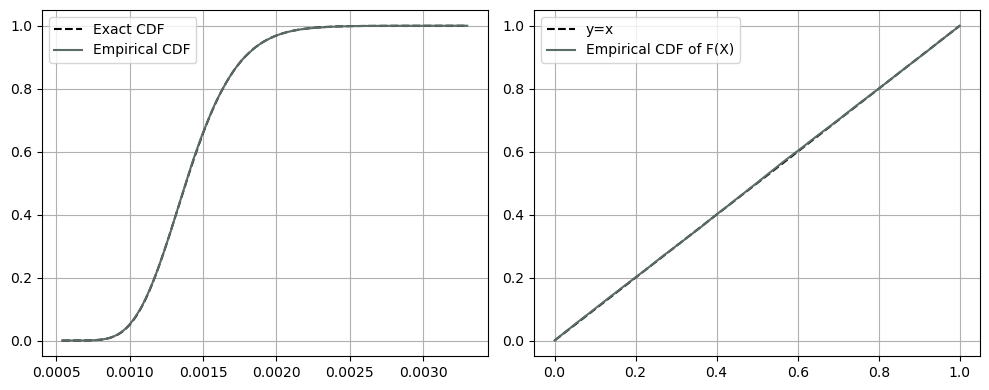

In [31]:
cdf_test(sample1, lambda x: invgauss.cdf(x=x, mu=mu/lam, loc=0, scale=lam))
cdf_test(sample2, lambda x: invgauss.cdf(x=x, mu=mu/lam, loc=0, scale=lam))